ToDo: add Delta hedge.

# Binomial Tree

In [235]:
import numpy as np
import matplotlib.pyplot as plt

sigma = 0.1
S = 80
T = 1.0
N = 200
K = 85
r = 0.1

In [236]:
def buildTree (S, vol , T, N):
    dt = T/N
    matrix = np.zeros((N+1, N+1))
    u = np.exp(vol*np.sqrt(dt))
    d = np.exp(-vol*np.sqrt(dt))    # Or 1/u
    for i in np.arange(N+1):        # iterate over rows
        for j in np.arange(i+1):    # iterate over columns
        # Hint : express each cell as a combination of up and down moves
            matrix[i, j] = S*(u**j * d**(i-j))

    return matrix 

In [237]:
print(buildTree(S, sigma, T, N))

[[ 80.           0.           0.         ...   0.           0.
    0.        ]
 [ 79.43630987  80.56769015   0.         ...   0.           0.
    0.        ]
 [ 78.87659157  80.          81.1394087  ...   0.           0.
    0.        ]
 ...
 [ 19.72634808  20.00730273  20.29225892 ... 324.43917016   0.
    0.        ]
 [ 19.58735373  19.86632874  20.14927709 ... 322.15313068 326.74143166
    0.        ]
 [ 19.44933875  19.72634808  20.00730273 ... 319.88319892 324.43917016
  329.0600303 ]]


In [238]:
def valueOptionMatrix (tree, T, N, r, K, vol, call=True):

    dt = T/N
    u = np.exp(vol*np.sqrt(dt))
    d = np.exp(-vol*np.sqrt(dt))    # Or 1/u
    p = (np.exp(r*dt)-d)/(u-d)      # risk-neutral probability

    columns = tree.shape[1]
    rows = tree.shape[0]

    # Walk backward, we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        S = tree[rows - 1, c]   # value in the matrix
        if call:
            tree[rows - 1, c] = max(0, S-K) # Should be higher than strike price, or worthless (Call case)
        else:
            tree[rows - 1, c] = max(0, K-S) # Should be higher than strike price, or worthless (Call case)

    # For all other rows, we need to combine from previous rows
    # We walk backwards, from the last row to the first row
    for i in np.arange(rows - 1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            tree[i, j] = np.exp(-r*dt) * (p*up+(1-p)*down)

    return tree


In [239]:
tree = buildTree(S, sigma, T, N)
print("EU Call Price: ", valueOptionMatrix(tree, T, N, r, K, sigma)[0,0])
tree = buildTree(S, sigma, T, N)
print("EU Put Price: ", valueOptionMatrix(tree, T, N, r, K, sigma, False)[0,0])
# Cross referenced with this site, results are correct
# https://www.optionseducation.org/toolsoptionquotes/optionscalculator

EU Call Price:  4.909059740163179
EU Put Price:  1.820240273221109


In [240]:
def valueOptionMatrixAmerican (tree, T, N, r, K, vol, call=True):

    dt = T/N
    u = np.exp(vol*np.sqrt(dt))
    d = np.exp(-vol*np.sqrt(dt))    # Or 1/u
    p = (np.exp(r*dt)-d)/(u-d)      # risk-neutral probability

    columns = tree.shape[1]
    rows = tree.shape[0]

    # Walk backward, we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        S = tree[rows - 1, c]   # value in the matrix
        if call:
            tree[rows - 1, c] = max(0, S-K) # Should be higher than strike price, or worthless (Call case)
        else:
            tree[rows - 1, c] = max(0, K-S) # Should be lower than strike price to be in money (Put case)

    # For all other rows, we need to combine from previous rows
    # We walk backwards, from the last row to the first row
    for i in np.arange(rows - 1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            if call:
                tree[i, j] = max(tree[i, j] - K , (np.exp(-r*dt) * (p*up+(1-p)*down)))  # Is it better to use continuation value or to excercise now
            else:
                tree[i, j] = max(K - tree[i, j] , (np.exp(-r*dt) * (p*up+(1-p)*down)))

    return tree

In [241]:
tree = buildTree(S, sigma, T, N)
print("US Call Price: ", valueOptionMatrixAmerican(tree, T, N, r, K, sigma)[0,0])
tree = buildTree(S, sigma, T, N)
print("US Put Price: ", valueOptionMatrixAmerican(tree, T, N, r, K, sigma, False)[0,0])
# Cross referenced with this site, results are correct
# https://www.optionseducation.org/toolsoptionquotes/optionscalculator

US Call Price:  4.909059740163179
US Put Price:  5.0


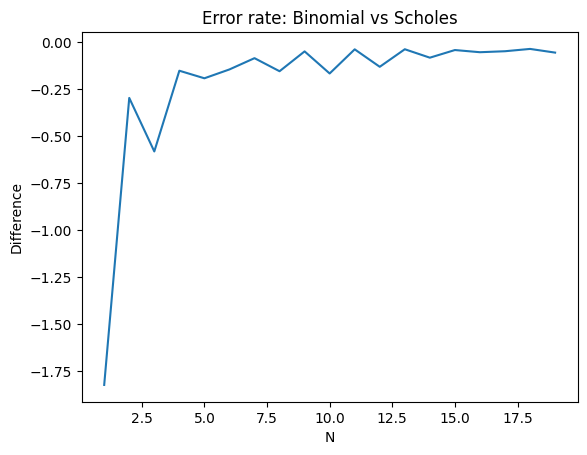

In [242]:
# Option params
sigma = 0.1
S = 80
T = 1.0
N_arr = np.arange(1, 20)  # Play around with different ranges of N and step sizes (1,300)
K = 85
r = 0.1

# Calculate the option price for the correct parameters
from part3 import d1_d2, call_option_price
d1, d2 = d1_d2(S, K, r, sigma, T)
optionPriceAnalytical = call_option_price(S, K, r, T, d1, d2)

# calculate option price for each n in N
priceApproximatedly = []
for n in N_arr:
    treeN = buildTree(S, sigma, T, n)
    priceApproximatedly.append(valueOptionMatrix(treeN, T, n, r, K, sigma)[0,0])

# use matplotlib to plot the analytical value
# and the approximated value for each n
plt.title("Error rate: Binomial vs Scholes")
plt.xlabel("N")
plt.ylabel("Difference")
plt.plot(N_arr, [y-optionPriceAnalytical for y in priceApproximatedly])